# Support vector classifier optimisation: SMO

In this notebook, we implement the Sequential Minimal Optimisation (SMO) algorithm to solve a non-linear classification problem using a support vector classifier. The implementation is based on [John Platt's paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf).

To test the implementation, we will use the moons dataset from Scikit-Learn. As there are only two features, it will be easy to visualise the resulting decision boundary. Let's first import the libraries that we will need and generate the dataset. Features scaling is applied to the dataset so that features have a mean of 0 and a standard deviation of 1. Also, the class label 0 is replaced by -1 as it is the norm for support vector classifiers. 

As the purpose of this notebook is to implement the optimisation algorithm, we do not split the dataset into a training set and a test set. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

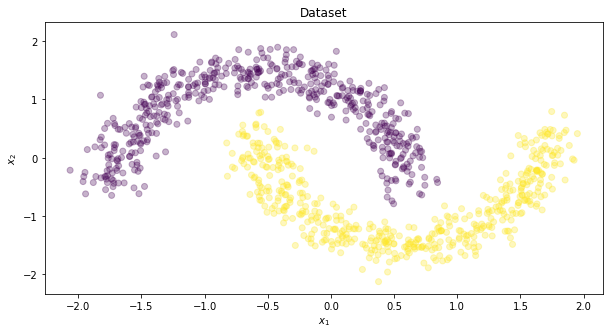

In [2]:
# Dataset creation
X, y = make_moons(n_samples=1000, noise=0.1, random_state=1)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X, y)
y[y == 0] = -1

# Plot the dataset
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(X_scaled[:,0], X_scaled[:,1], c=y, alpha=0.3)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Dataset');

# Support vector classifier

In this section, we briefly show the mathematical formulation of support vector classifiers. This is not meant to be an extensive treatment of the subject. Instead, the goal is to show the key steps of the derivation of the optimisation problem.

A support vector classifier is mathematically defined as 

\begin{equation}
	f(x) = w^Tx + b
\end{equation}

where $w$ is a vector of weights, $x$ is a vector of features and $b$ is a bias term. Then, $f(x)$ is used to predict the class label vector, $\hat{y}$, 

\begin{equation}
	\hat{y} = \begin{cases} 1, & f(x) \geq 0 \\
				   -1, & f(x) < 0
	\end{cases}
\end{equation}

The optimisation problem for a hard margin classifier can be formulated as 

\begin{equation}
	\begin{gathered}
		\min_{w, b} \frac{1}{2} \lVert w \rVert^2 \\
		\text{subject to } y_i(w^T x_i + b) \geq 1 \\
	\end{gathered}
\end{equation}

Here, we want to implement a soft margin classifier which allows for some misclassification. Introducing a slack variable $\xi_i$, the optimisation problem can be reformulated as 

\begin{equation}
	\begin{gathered}
		\min_{w, b, \xi_i} \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i \\
		\text{subject to } \xi_i \geq 0, \,\, y_i(w^Tx_i + b) \geq 1- \xi_i
	\end{gathered}
\end{equation}

where the hyperparameter $C$ is a regularisation constant controlling the tradeoff between minimising the loss and maximising the margin. This is the objective function of a SVM with hinge loss. When $y_i(w^Tx_i + b) > 1$, no loss is needed. Hence, the constraint $y_i(w^Tx_i + b) \geq 1- \xi_i$ can be rewritten as

\begin{equation}
	\xi_i = \max \big(0, 1 - y_i(w^Tx_i + b)\big)
\end{equation}

Introducing the Lagrange multipliers, $\alpha_i$ and $\lambda_i$, the Lagrangian primal function, $\mathcal{L}_P$, is defined as

\begin{equation}
	\begin{aligned}
		\mathcal{L}_P &= \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i + \sum_{i=1}^N \alpha_i \big(1 - \xi_i - y_i(w^T x_i + b)\big) + \sum_{i=1}^N \lambda_i(0 - \xi_i) \\
				&= \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i - \sum_{i=1}^N \alpha_i \big(y_i(w^T x_i + b) - 1 + \xi_i \big) - \sum_{i=1}^N 			\lambda_i\xi_i\\		
	\end{aligned}
\end{equation}

Taking the partial derivatives with respect to $w$, $b$ and $\xi_i$, and setting them to zero, we obtain

\begin{alignat}{3}
    \frac{\partial \mathcal{L}}{\partial w} &= w - \sum_{i=1}^N \alpha_i y_i x_i = 0 \;\; &&\implies \;\; w = \sum_{i=1}^N \alpha_i y_i x_i \\
    \frac{\partial \mathcal{L}}{\partial b} &= \sum_{i=1}^N \alpha_i y_i = 0 \;\; &&\implies \;\; 0 = \sum_{i=1}^N \alpha_i y_i \\
    \frac{\partial \mathcal{L}}{\partial \xi_i} &= C - \alpha_i - \lambda_i = 0 \;\; &&\implies \;\; \alpha_i = C - \lambda_i, \,\, \forall i
\end{alignat}

Plugging these into $\mathcal{L}_P$, we obtain the Lagrange dual function, $\mathcal{L}_D$,

\begin{equation}
	\begin{aligned}
		\mathcal{L}_D &=  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i - \sum_{i=1}^N \alpha_i \big(y_i(w^T x_i + b) - 1 + \xi_i\big) - \sum_{i=1}^N \lambda_i \xi_i	\\
		&= \frac{1}{2} w^Tw - w^T \left(\sum_{i=1}^N \alpha_i y_i x_i \right) - b \sum_{i=1}^N \alpha_i y_i + \sum_{i=1}^N \alpha_i + 				\sum_{i=1}^N (C - \alpha_i - \lambda_i)\xi_i \\		
		& = \sum_{i=1}^N \alpha_i - \frac{1}{2} w^Tw \\
		& = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j x_i^Tx_j
	\end{aligned}
\end{equation}

As we want to handle cases where the data is not linearly separable, we consider a transformation of $x_i$, $\phi(x_i)$, which converts the original feature space to a higher dimensional feature space. Then, we use the kernel trick to compute $\phi(x_i)^T\phi(x_j)$. Note that we do not need to know the feature mapping $\phi(.)$ because we only use kernels to compute the inner product. Here, we are going to use the Gaussian kernel which is defined as

\begin{equation}
	K(x_1, x_2) = \exp \left(-\frac{\lVert x_1 - x_2 \rVert^2}{2 \sigma^2}\right)
\end{equation}

Our Lagrange dual function, $\mathcal{L}_D$, becomes

\begin{equation}
	\begin{aligned}
		\mathcal{L}_D &= \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j \phi(x_i)^T\phi(x_j) \\
		& = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j)
	\end{aligned}
\end{equation}

While $\mathcal{L}_P$ should be minimised, $\mathcal{L}_D$ should be maximised with respect to $\alpha_i$. Therefore, the dual optimisation problem that we want to solve with SMO is

\begin{equation}
	\begin{gathered}
		\max_{\alpha} \mathcal{L}_D = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
		\text{subject to } 0 \leq \alpha_i \leq C, \,\, \sum_{i=1}^N \alpha_i y_i = 0	
	\end{gathered}
\end{equation}

Finally, the predicted class label is computed as 

\begin{equation}
    \hat{y} = \text{sign} \left( \sum_{i = 1}^N \alpha_i y_i K(x_i, x) + b \right)
\end{equation}

# Implementation

SMO solves the above quadratic programming problem by breaking it into the smallest possible subproblems. As the Lagrange multipliers are subject to an equality constraint, the smallest possible optimisation subproblem involves two Lagrange multipliers. One of the advantages of SMO is that there is an analytical solution for solving for two Lagrange multipliers. Therefore, there is no need to use numerical QP optimisation. Another advantage lies in the fact that SMO does not require extra matrix storage.

First, let's implement the algorithm based on the pseudo-code found in [John Platt's paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf).

In [3]:
def SMO_main(X, y, alphas, b, kernel, C, errors, N):
    
    alphas_info = np.zeros(N)
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over the whole training set
            for i in range(N):
                res, alphas, b, errors = examine_example(i, X, y, alphas, b, kernel, C, errors, N)
                numChanged += res
            alphas_info = np.vstack((alphas_info, alphas))
        else:
            # loop over examples where alphas are not at bound
            for i in np.where((alphas != 0) & (alphas != C))[0]:
                res, alphas, b, errors = examine_example(i, X, y, alphas, b, kernel, C, errors, N)
                numChanged += res
            alphas_info = np.vstack((alphas_info, alphas))
            
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return alphas, b, alphas_info

In [4]:
def examine_example(i2, X, y, alphas, b, kernel, C, errors, N):
    
    y2 = y[i2]
    alph2 = alphas[i2]
    E2 = errors[i2]
    r2 = E2 * y2

    # Check if error is within tol
    if ((r2 < -tol and alph2 < C) or (r2 > tol and alph2 > 0)):       
        if len(alphas[(alphas != 0) & (alphas != C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if errors[i2] > 0:
                i1 = np.argmin(errors)
            elif errors[i2] <= 0:
                i1 = np.argmax(errors)
            res, alphas, b, errors = take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N)
            
            if res:
                return 1, alphas, b, errors
            
        # Loop through alpha different from 0 or C
        # Starting randomly
        for i1 in np.roll(np.where((alphas != 0) & (alphas != C))[0], np.random.choice(np.arange(N))):
            res, alphas, b, errors = take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N)
            if res:
                return 1, alphas, b, errors
        
        # loop through all alphas
        # Starting randomly
        for i1 in np.roll(np.arange(N), np.random.choice(np.arange(N))):
            res, alphas, b, errors = take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N)
            if res:
                return 1, alphas, b, errors
    
    return 0, alphas, b, errors

In [5]:

def take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N):
    
    # Stop function if the same alphas are selected
    if i1 == i2:
        return 0, alphas, b, errors
    
    alph1 = alphas[i1]
    alph2 = alphas[i2]
    y1 = y[i1]
    y2 = y[i2]
    E1 = errors[i1]
    E2 = errors[i2]
    s = y1 * y2
    
    # Compute the bounds L and H
    # Equations (13) and (14) of the original paper
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(C, C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - C)
        H = min(C, alph1 + alph2)
    if (L == H):
        return 0, alphas, b, errors

    # Evaluate kernel
    k11 = kernel(X[i1], X[i1])
    k12 = kernel(X[i1], X[i2])
    k22 = kernel(X[i2], X[i2])
    eta = k11 + k22 - 2 * k12 # second derivative
    
    # Compute new alpha_2 if eta is positive
    if (eta > 0):
        a2 = alph2 + y2 * (E1 - E2) / eta
        # Clip a2 
        if a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H
            
    # Change a2 if eta is not positive
    else:
        alphas_modified = alphas.copy()
        alphas_modified[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_modified, y, kernel, X) 
        alphas_modified[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_modified, y, kernel, X)
        
        if Lobj < (Hobj - eps):
            a2 = L
        elif Lobj > (Hobj + eps):
            a2 = H
        else:
            a2 = alph2
                
    # Stop function if optimisation fails
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, alphas, b, errors
    
    # Calculate new alpha_1 
    a1 = alph1 + s * (alph2 - a2)
    
    # Update b
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average b if at bound for alpha_1 and alpha_2
    else:
        b_new = (b1 + b2) * 0.5

    # Update alpha
    alphas[i1] = a1
    alphas[i2] = a2
    
    # Update error for alpha_1 and alpha_2
    # Error to 0 if unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < C:
            errors[index] = 0.0
    
    # Update error for examples that were not optimised
    no_opt = [n for n in range(N) if (n != i1 and n != i2)]
    errors[no_opt] = errors[no_opt] + y1*(a1 - alph1)*kernel(X[i1], X[no_opt]) \
                        + y2*(a2 - alph2)*kernel(X[i2], X[no_opt]) + b - b_new
    
    # Update b
    b = b_new
    
    return 1, alphas, b, errors

Let's create a function for our objective function. To be consistent with [John Platt's paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf), we are going to minimise $-\mathcal{L}_D$ (which is equivalent to maximising $\mathcal{L}_D$).

In [6]:
def objective_function(alphas, y, kernel, x):    
    return -np.sum(alphas) + 0.5 * np.sum((y[:, np.newaxis] * y[np.newaxis, :]) 
                                          * kernel(x, x) * (alphas[:, np.newaxis] * alphas[np.newaxis, :]))

We create a function for the Gaussian kernel.

In [7]:
def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        return np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        return np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        return np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))

We create a function to classify the inputs.

In [8]:
def classify_func(alphas, y, kernel, X, x_test, b):
    return (alphas * y) @ kernel(X, x_test) + b

Finally, we create a function which will plot the decision boundary. This will be useful to visualise the classification result.

In [9]:
def plot_decision_boundary(alphas, X, y, b, kernel, ax):
    
    # Evaluate model over 100x100 grid
    xrange = np.linspace((X[:,0].min())*1.05, (X[:,0].max())*1.05, 100)
    yrange = np.linspace((X[:,1].min())*1.05, (X[:,1].max())*1.05, 100)
    grid = [[classify_func(alphas, y,kernel, X, np.array([xr, yr]), b) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))
    
    # Plot the classify function contours using the grid
    ax.contour(xrange, yrange, grid, levels=(-1, 0, 1), linewidths=(1, 1, 1), 
               linestyles=('--', '-', '--'), colors=('b', 'k', 'r'))
    # Scatter plot of the dataset
    ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.viridis, lw=0, alpha=0.3)
    
    # Plot support vectors (circled)
    non_zero_alpha = np.round(alphas, decimals=2) != 0.0
    ax.scatter(X[non_zero_alpha, 0], X[non_zero_alpha, 1], c=y[non_zero_alpha], 
               cmap=plt.cm.viridis, lw=1, edgecolors='k')
    
    return grid, ax

# Testing the algorithm

First, let's initialise the parameters. The hyperparameters $C$ and $\sigma$ could be found using optimisation techniques but this is not the purpose of this notebook. A lower value of $C$ increases the strength of the regularisation. Indeed, as $C \to \infty$, we recover a hard margin SVM. The spread parameter $\sigma$ in the Gaussian kernel plays the same role as the standard deviation in the normal density function. A low value of $\sigma$ can lead to overfitting. 

In [10]:
# Set model parameters and initial values
X = X_scaled
C = 1 # regularisation constant
N = len(y)
alphas = np.zeros(N) # initial alphas
b = 0.0 # initial b
sigma = 0.5
kernel = lambda x, y: gaussian_kernel(x, y, sigma=sigma)

# Set tolerance parameters
tol = 0.001 # error tolerance
eps = 0.001 # alpha tolerance

# Error initialisation
errors = classify_func(alphas, y, kernel, X, X, b) - y

Now, we train the model and print the training time. 

In [11]:
# Model training
time_start = time.time()
alphas, b, alphas_info = SMO_main(X, y, alphas, b, kernel, C, errors, N)
time_end = time.time()

print("The model was trained in " + str(round(time_end - time_start, 2)) + " seconds.")

The model was trained in 8.1 seconds.


Let's plot the decision boundary.

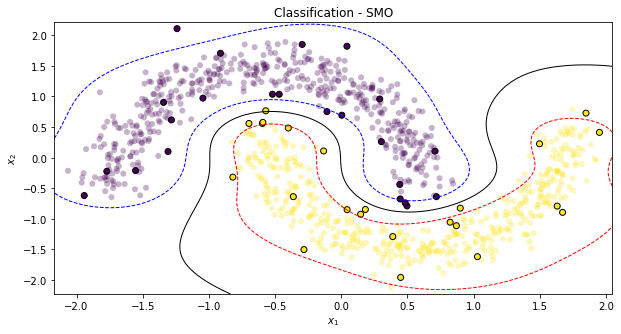

In [12]:
# Plot the decision boundary
fig, ax = plt.subplots(figsize=(10, 5))
grid, ax = plot_decision_boundary(alphas, X, y, b, kernel, ax)
ax.set_title('Classification - SMO')
ax.set_xlim((X[:,0].min())*1.05, (X[:,0].max())*1.05)
ax.set_ylim((X[:,1].min())*1.05, (X[:,1].max())*1.05)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$');

We also plot the confusion matrix which shows the classification result.

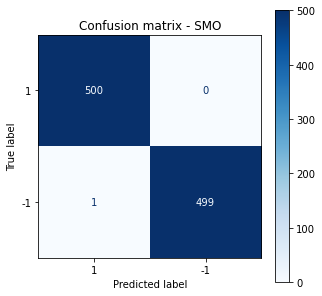

In [13]:
# Predict the class label for each sample
pred = []
for k in range(len(y)):
    check = classify_func(alphas, y, lambda i, j: gaussian_kernel(i, j, sigma=sigma), 
                          X, np.array([X[k,0], X[k,1]]), 0)
    pred.append(np.sign(check))

# Create the confusion matrix
cm = confusion_matrix(y, pred)

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp = disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix - SMO');

# Convergence

Finally, we can analyse the convergence of the algorithm by plotting the Q-convergence. It is done by plotting

\begin{equation}
    \frac{\lVert \alpha_{t + 1} - \alpha^* \rVert}{\lVert \alpha_t - \alpha^* \rVert}
\end{equation}

where $\alpha_t$ is the $\alpha$ vector at iteration $t$ and $\alpha^*$ is the optimal $\alpha$ vector (i.e. the one to which the algorithm has converged).

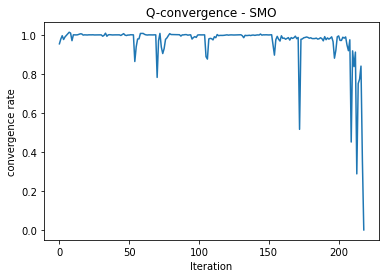

In [14]:
# Compute the norm of the difference between alpha_t and alpha*
c = []
for i in range(len(alphas_info)):
    c.append(np.linalg.norm(alphas_info[i] - alphas_info[-1]))

# Q-convergence plot    
fig = plt.figure()
ax = fig.add_subplot(111)
with np.errstate(invalid='ignore'):
    ax.plot(np.divide(c[1:], c[0:-1]))
ax.set_xlabel('Iteration')
ax.set_ylabel('convergence rate')
ax.set_title('Q-convergence - SMO');

We can also investigate the exponential convergence plot by plotting

\begin{equation}
    \ln \left( \lVert \alpha_t - \alpha^* \rVert \right)
\end{equation}

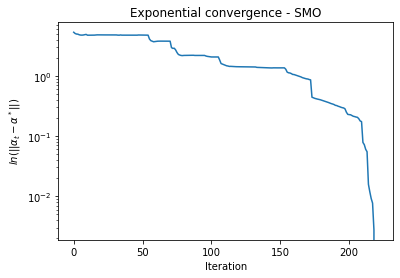

In [15]:
# Exponential convergence plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(c)
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$ln(||\alpha_t - \alpha^*||)$')
ax.set_title('Exponential convergence - SMO');